In [20]:
!pip install torch

  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached triton-2.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (167.9 MB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinu

# About



`ITS_LIVE_TOOL` is a package designed to aid users working with the [Inter-mission Time Series of Land Ice Velocity and Elevation](link) (ITS_LIVE) dataset. The package provides functions for accessing data as well as various methods to process ITS_LIVE observations. This notebook will demonstrate various elements of the package and walk through the steps of a typical workflow using ITS_LIVE_TOOL. 

## Overview 

- Data Access
- Organization
- Data Processing
- Velocity Inversion

### Data Access + Organization

#### 1. Interactive map widget

This is an interactive widget design to streamline access ITS_LIVE image pair ice velocity time series. 

#### 2. Organization: `Glacier`, `Glacier_Centerline`, `Glacier_Point` objects

These are provided to store and keep track of different types of data related to individual units of analysis such as points, centerlines or full glacier surface areas. 

This roadmap document will first demonstrate data access and organization tools before demonstrating the processing tools. 

### Data Processing

We demonstrate and make available two processing routines. Be sure to check out the accompanying [book]() and consider if either of these are appropriate for your data and use case. Note that these methods are in active development and thus should be considered in *beta* phase. Please perform your own data inspection and due diligence if implementing these methods. 

#### Inversion

The Velocity Inversion solves ITS_LIVE's velocity timestamp issue. It inputs the length in time of all satellite pairs and recalculates a velocity that weighs each ITS_LIVE velocities falling withing the same time-window. It is a way of correcting and interpolating the dataset.


#### Gaussian Process Regression 

**to add**
Description -- link to full description and examples


### Processing

We demonstrate and make available two processing routines. Be sure to check out the accompanying [book]() and consider if either of these are appropriate for your data and use case. Note that these methods are in active development and thus should be considered in *beta* phase. Please perform your own data inspection and due diligence if implementing these methods. 

In [1]:
!pip install owslib
!pip install s3fs
!pip install zarr
!pip install hdf5

ERROR: Could not find a version that satisfies the requirement hdf5 (from versions: none)
ERROR: No matching distribution found for hdf5


In [2]:
%load_ext autoreload
%autoreload 2
from ITS_LIVE_TOOL import datacube_tools, interactive, obj_setup, invert_SBAS
import os
import numpy as np
import pyproj
import matplotlib.path as path
import s3fs
import zarr
import matplotlib.pyplot as plt
import scipy
from datetime import timedelta
from tqdm import tqdm
import xarray as xr
import re
import pandas as pd
import geopandas as gpd
import matplotlib.path as mplp
import ipyleaflet as ipyl
from ipyleaflet import WMSLayer
import ipywidgets as ipyw
import json
import pandas as pd
from ipyleaflet import Map, WMSLayer, basemaps, GeoData
from ipywidgets import HTML
from owslib.wms import WebMapService
from scipy.interpolate import make_interp_spline
from datetime import timedelta
from shapely.geometry import shape, Polygon
import matplotlib.patches as patches
try:
    import torch
except:
    print('Could not import pytorch. Relevant only if you want to use GPU.')

torch was not imported, you are not on the GPU server
torch import failed. Is it installed ?
Could not import pytorch. Relevant only if you want to use GPU.


## Install

Install this package using the below command 

```{note}
someday we hope to have a pip or conda install, for now use pip install git+ github repo url
```

# Section 1: Data Access + Organization

### How to use

There are two ways to access data using ITS_LIVE_TOOL. The first way is through the interactive widget. This is great for exploratory analysis. The second way is by specifying an RGI ID and point coordinates manually. This is useful if you already know which glacier(s) you want to examine and simply want to pass a list of RGI IDs and coordinates. We'll first demonstrate using the interactive widget.

### Interactive data selection widget

First, use the interactive map to select data. Do this by right- and left-clicking on the map location where you'd like to access data. 
This will return an object containing the coordinates of the point you clicked, a `geopandas.GeoDataFrame` of the [RGI7](http://www.glims.org/rgi_user_guide/welcome.html) data for that glacier and the URL of the ITS_LIVE granule covering the clicked point. 

```{note}
If the glacier you want to study lies in multiple ITS_LIVE granules, or you'd like to look at multiple glaciers, click in multiple points and the output objects will be appended with each click. 
```

In [3]:
#| eval: false
#| output: false

data_map = interactive.Widget()

In [4]:
#| eval: false
#| output: false

data_map.display()

GridBox(children=(VBox(children=(Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text',…


# Section 3: Datacube Inversion

#### *To dive into the theory of the inversion, check-out the '06_inversion.ipynb' notebook*
<br>

#### **Problem:**

*Find a smooth regularly spaced timeseries of velocities given a set of average measurements of possibly overlapping and variable length time intervals*

<br>


#### **Inversion applied to ITS_LIVE:**

ITS_LIVE is a great dataset that achieves high-density measurements globally, on a long timescale, using the same sensors and method.
However it suffers from one main problem: **mid_dates** (timestamps), its attribution of a timestamp for a measurement. For example, if ITS_LIVE uses two images a month apart, it really measures the average velocity for this whole month. Instead, ITS_LIVE attributes to the velocity a timestamp in the middle of the month. 

The inversion computes all the timestamps and the satellite-pairs length, and calculates a solution depending on all the available values.

<br>



### **Input your parameters below**

*Useful information:*

- GPU generally runs the inversion faster, but might be slower when using the spatial regularization.
- High lambda encouraged for non-surging glacier
- spatial_shape 'cross' is hard-coded because 'ring' would take a lot of RAM and the code would be much more complicated.
- spatial_regularization: False if you want a faster computation, slightly less accurate.

In [5]:
# In case you didn't run the cell that grabs the urls
coords, gpdf, urls = obj_setup.return_clicked_info(data_map)

# In case you haven't created the centerline
#glacier_centerline = obj_setup.create_glacier_centerline_from_click(data_map, 0)

name_cube = 'Jakobshavn' # Name of the dataset

mission = ['1A', '1B', '8', '2A', '2B', '7', '5'] # 'None' if you want all the data. You can enter it as a list, make sure that you also modify sdate and edate accordingly (example: ['1A','8']). Possible options: '1A', '1B', '2A', '2B', '4', '5', '7', '8', '9']

days_interval = 15 # Amount of days in between each inversion value. The higher, the faster the inversion. But you also lose in temporal resolution. 12 here because Sentinel-1 repeat-time is 12.

sdate = ['2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01', '2000-01-01', '2000-01-01']#, '2000-01-01']#, '2000-01-01',] # Start date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available

edate = ['2024-01-01', '2024-01-01', '2024-01-01', '2024-01-01', '2024-01-01', '2014-01-01', '2014-01-01']#, '2024-01-01']#, '2015-01-01'] # End date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available

GPU = False # True if you want to use GPU, False if you want to use CPU

if GPU:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = None

spatial_regularization = True # True if you want to use spatial regularization, False if you only want to use temporal regularization

sparse = True # Might speed-up the inversion. Doesn't matter if GPU is True

size_subarrays = 100 # Determines size of subarrays (NxN). Choose N. The larger, the faster the inversion. But if you have RAM issues, consider lowering it (try increments of half). 



arg_dict = {
    'coords': coords,
    'gpdf': gpdf,
    'urls': urls,
    #'glacier_centerline': glacier_centerline,
    'name_cube': name_cube,
    'mission': mission,
    'days_interval': days_interval,
    'sdate': sdate,
    'edate': edate,
    'GPU': GPU,
    'spatial_regularization': spatial_regularization,
    'sparse': sparse,
    'data_map': data_map,
    'size_subarrays': size_subarrays,
    'device': device
}


You have 2 glaciers selected


**Create dictionnaries to hold variables for each datacube**

Each datacube has multiple variables associated with it. We gather all these variables in dictionnaries such as 1 datacube = 1 dictionnary.
We then gather all the dictionnaries into one for easier organization.


Calculating overlay glaciers/polygon......
......Execution time: 1.65 seconds
Fetch datacubes information......
......Execution time: 1.49 seconds
......Execution time: 1.49 seconds
Starting creating the template (this step can take a few minutes) ......


100%|██████████| 68816/68816 [00:15<00:00, 4443.05it/s] 


......Execution time: 15.5 seconds
Starting subdividing the area of interest......


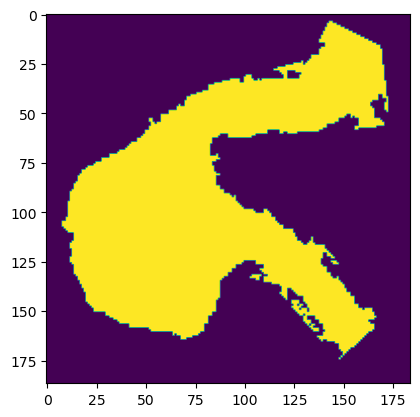

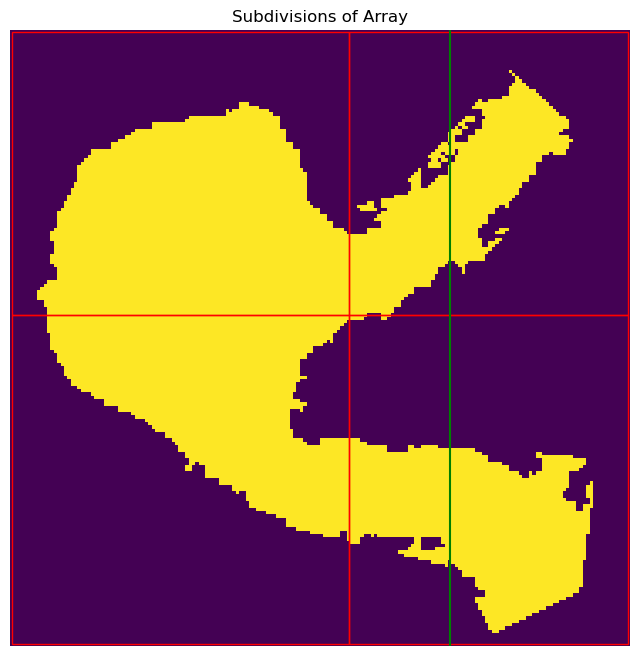

......Execution time: 3.12 seconds


In [6]:
var_dict = invert_SBAS.prepare_data(arg_dict)

### Select a point on the template that is on-ice, and surrounded by ice
Do this by choosing values for xp and yp

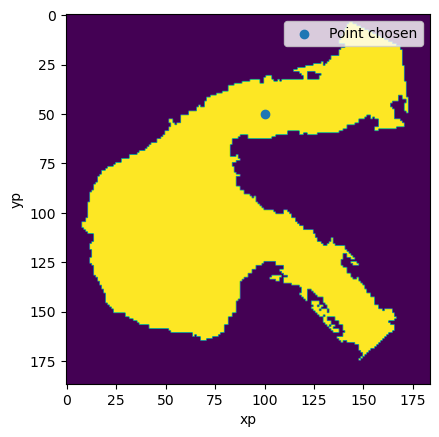

In [8]:
xp = 100 # Choose 
yp = 50 # Choose

# Plots the template and the point you chose in blue
plt.figure()
plt.imshow(var_dict['template'])
plt.scatter(xp, yp, label = 'Point chosen')
plt.xlabel('xp')
plt.ylabel('yp')
plt.legend()

Run this cell to load the velocities for this point and its neighbors

The point belongs to the subarray: 1


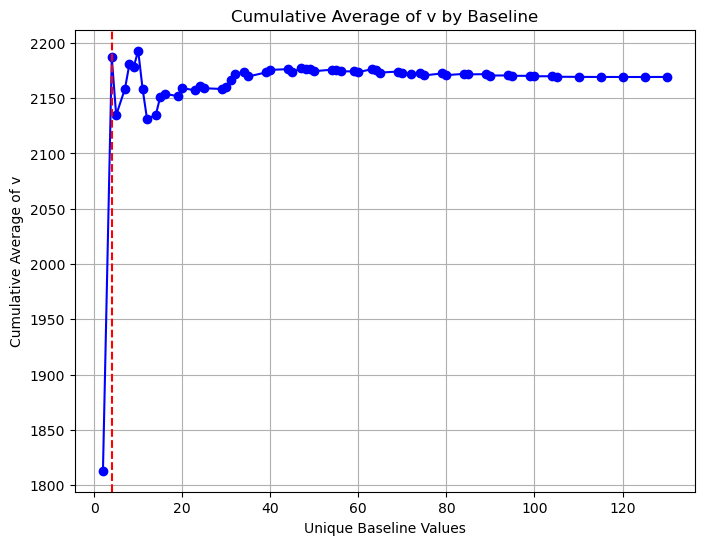

Most likely cutout for baseline of 4 days


In [9]:
df, neighbors, subarray_dict = invert_SBAS.likely_cutout(xp, yp, var_dict, arg_dict)

<Axes: xlabel='time', ylabel='v'>

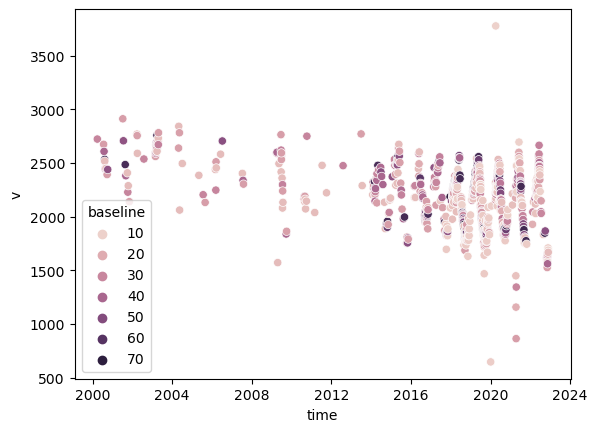

In [17]:
import seaborn as sns
# User input for cutout value
cutout_min = 10
cutout_max = 70

# Save in var_dict
var_dict['cutout_min'] = cutout_min
var_dict['cutout_max'] = cutout_max

# Filter out rows where 'baseline' is above the cutout value
sns.scatterplot(data=df[(cutout_min <= df['baseline']) & (df['baseline'] <= cutout_max)], 
                x='time', y='v', hue='baseline')

### Choose regularization factors

There are two regularization factors: lambda_space and lambda_time.
They each impact how smooth in space or time the inversion will be.

Try it out by changing the values ! 

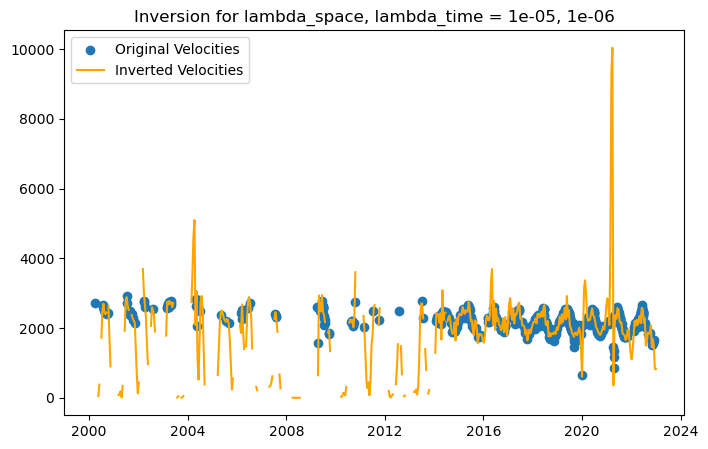

In [18]:
arg_dict['sparse'] = True
lambda_space, lambda_time = 1e-5, 1e-6 # Change the values here


vx, vy, v, mid_dates = invert_SBAS.Interpolator(arg_dict, var_dict, neighbors, subarray_dict, lambda_space, lambda_time, pt = True)

plt.figure(figsize=(8,5))
plt.scatter(mid_dates, v, label='Original Velocities')
plt.plot(var_dict['regular_dates'], np.sqrt(vx**2+vy**2), label = 'Inverted Velocities', color = 'orange')
plt.title(f"Inversion for lambda_space, lambda_time = {lambda_space}, {lambda_time}")
plt.legend()

In [ ]:
vxInv = np.full((len(var_dict['regular_dates']), var_dict['template'].shape[0], var_dict['template'].shape[1]), np.nan)
vyInv = np.full((len(var_dict['regular_dates']), var_dict['template'].shape[0], var_dict['template'].shape[1]), np.nan)

with tqdm(total=var_dict['valid_pixels']) as pbar:
    counter = 0

    for iterator in var_dict['valid_subcubes']:
        
        subarray_dict, indices_dict = invert_SBAS.prepare_subcube(iterator, var_dict, arg_dict) # Get ITS_LIVE data
        i_ice, j_ice = np.where(indices_dict['subarray'] == 1) # Get indices of on-ice pixels
        ymin_inv = indices_dict['corners'][0][0] # Get y index of the subarray considered in the template reference
        xmin_inv = indices_dict['corners'][0][1] # Get x index of the subarray considered in the template reference

        for i,j in zip(i_ice, j_ice):
            neighbors = invert_SBAS.grab_cross_around_pixel(subarray_dict, indices_dict['subarray'], i, j)
            vxInv[:, ymin_inv + i, xmin_inv + j], vyInv[:, ymin_inv + i, xmin_inv + j] = invert_SBAS.Interpolator(arg_dict, var_dict, neighbors, subarray_dict, lambda_space, lambda_time)
            # Save the amount of iterations in a text file
            if counter%100 == 0:
                with open("Counter.txt", "w") as text_file:
                    text_file.write(f"Counter: {counter}")
            if counter%5000 == 0:
                plotting = False
                invert_SBAS.save_dataset(plotting, arg_dict, var_dict, vxInv, vyInv)     
            pbar.update(1)
            counter += 1

plotting = True
invert_SBAS.save_dataset(plotting, arg_dict, var_dict, vxInv, vyInv)   

  0%|          | 0/12680 [00:00<?, ?it/s]

Writing to Datacubes/Jakobshavn
[########################################] | 100% Completed | 2.62 sms


 14%|█▍        | 1831/12680 [5:04:04<68:01:00, 22.57s/it] 